# Demographic income

The dataset contains a set of demographic attributes for people in the US.

[Adult UCI Dataset](http://archive.ics.uci.edu/ml/datasets/Adult)

You have to build a model to predict whether their salary is higher or lower than 50K.

## 1. Data exploration

The data is contained in the database file: `../../assets/datasets/adult.sqlite`

Load the data into a Pandas Dataframe.

In [2]:
import pandas as pd
import seaborn as sns
import sqlite3
from pandas.io import sql

# set up sqlite3 connection to adult db
connection = sqlite3.connect('../../assets/datasets/adult.sqlite')
c = connection.cursor()

# check out the list of tables in the db
sql.read_sql('select * from sqlite_master', connection)

,type,name,tbl_name,rootpage,sql
0,table,SELECT * FROM adult;,SELECT * FROM adult;,6187,"CREATE TABLE ""SELECT * FROM adult;"" (\n""index""..."
1,index,ix_SELECT * FROM adult;_index,SELECT * FROM adult;,6188,"CREATE INDEX ""ix_SELECT * FROM adult;_index""ON..."
2,table,adult,adult,2,"CREATE TABLE ""adult"" (\n""age"" INTEGER,\n ""wor..."


In [3]:
# only table is adult, read into pandas df
adult = sql.read_sql_query('select * from adult',connection)
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1 Missing values

Are there any missing values?
How will you deal with them?

Discuss this with your classmate and decide on a strategy for imputation

In [4]:
adult.isnull().sum()
#workclass = 2799
#occupation = 2809
#native-country = 857

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
salary               0
dtype: int64

In [5]:
sql.read_sql_query('select "hours-per-week" ,count(*)from adult where workclass is null and occupation is  null group by "hours-per-week" order by count(*) desc',connection)

,hours-per-week,count(*)
0,40,1033
1,20,238
2,30,204
3,35,135
4,25,126
5,15,99
6,10,82
7,50,81
8,45,65
9,8,64


In [6]:
# sql.read_sql_query('select race,count(*) from adult where "native-country" is null group by race',connection)

# sql.read_sql_query('select "native-country", count(*) from adult where race == "White" group by race, "native-country" order by race, count(*) desc',connection)


# After looking at breakdowns of race and native-country, 
# I'm going to go ahead and set null native-country cells to United-States
# Most races have the US listed as the native-country with the most people
# and on top of that, there are only 857 null native-countries so I don't
# think that this will have a huge impact on the data
adult['native-country'].fillna('United-States',inplace=True)

print adult['native-country'].isnull().sum()


# I'm going to drop rows with null jobs, workclass
adult.dropna(axis=0,inplace=True)
print adult['occupation'].isnull().sum()


# drop duplicates
adult.drop_duplicates(inplace=True)

0
0


## 2. Target

Salary is separated in 2 classes '<=50K' and '>50K'.

Create a new boolean variable called target that is True for salary >50K and False otherwise

In [7]:
adult['target'] = adult.salary=='>50K'

### 3 Features

The dataset contains many features.

- Are they numerical?
- Are they categorical?

In [8]:
adult.education.value_counts()


# age                int64 NUMERICAL
# workclass         object CATEGORICAL:
# fnlwgt             int64 NUMERICAL
# education         object CATEGORICAL:
# education-num      int64 
# marital-status    object CATEGORICAL:
# occupation        object CATEGORICAL:
# relationship      object CATEGORICAL:
# race              object CATEGORICAL:
# sex               object CATEGORICAL:
# capital-gain       int64
# capital-loss       int64
# hours-per-week     int64
# native-country    object CATEGORICAL:


HS-grad         14958
Some-college    10024
Bachelors        7761
Masters          2589
Assoc-voc        1977
11th             1631
Assoc-acdm       1529
10th             1239
7th-8th           843
Prof-school       810
9th               687
12th              597
Doctorate         576
5th-6th           466
1st-4th           227
Preschool          71
Name: education, dtype: int64

### 3.a Age distribution

What is the distribution of age? How does age correlate with the outcome variable?

- Plot a histogram of the age column
- Separate by target variable and plot the age distribution for the 2 classes

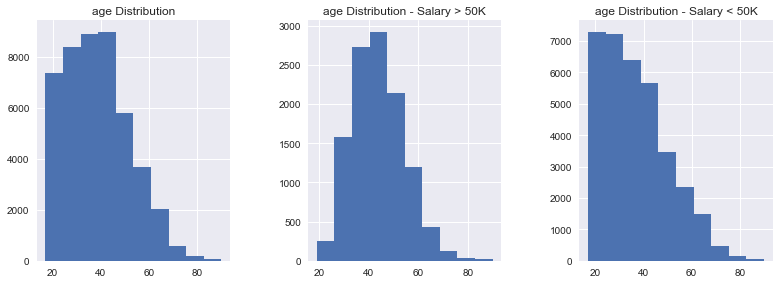

In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def hist_target(feature):
    
    plt.close('all')
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
    plt.tight_layout(pad=5, w_pad=5, h_pad=5)

    ax1.hist(adult[feature])
    ax1.set_title( feature + ' Distribution')

    ax2.hist(adult[feature][adult['target']==True])
    ax2.set_title( feature + ' Distribution - Salary > 50K')

    ax3.hist(adult[feature][adult['target']==False])
    ax3.set_title(feature + ' Distribution - Salary < 50K')

    
hist_target('age')

The only thing that is clearly visible is that there are many more young people in the low income class.

### 3.b Categorical Features Distributions

Investigate the relation of each categorical feature with the salary class:

- workclass
- education
- marital-status
- occupation
- relationship
- race
- sex

Use a bar-chart to visualize the relative frequency of each of the  elements in the group.
Use two colors to distinguish between the low and high salary class.

For which features is there significant difference in ratios?

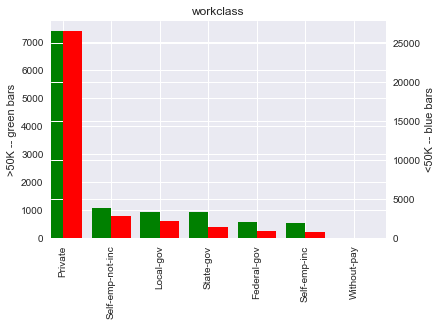

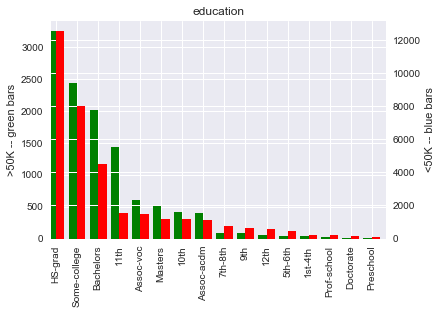

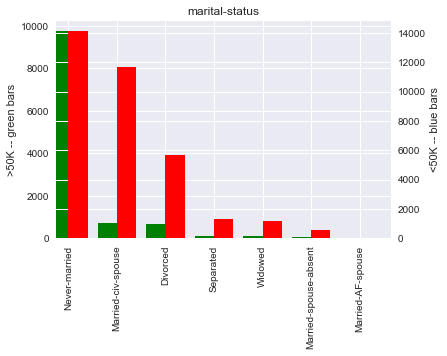

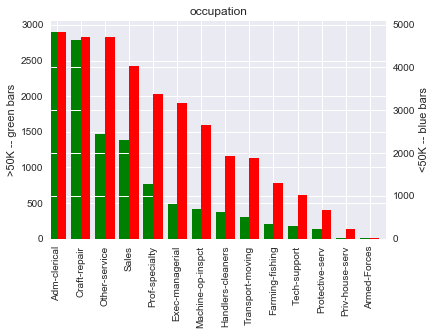

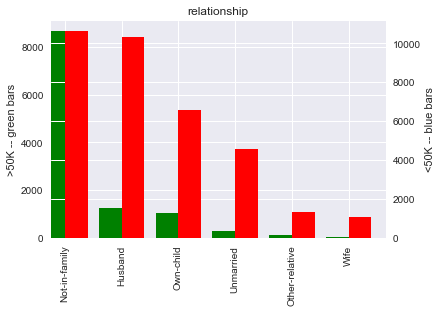

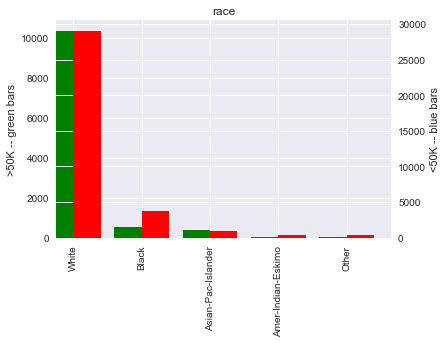

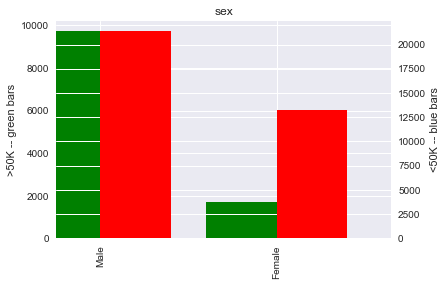

In [10]:


def plot_by_target(features):
    for feature in features:
        fig = plt.figure() # Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        adult[feature][adult.target==True].value_counts().plot(kind='bar', color='green', ax=ax, width=0.4, position=1)
        adult[feature][adult.target==False].value_counts().plot(kind='bar', color='red', ax=ax2, width=0.4, position=0)

        ax.set_ylabel('>50K -- green bars')
        ax2.set_ylabel('<50K -- blue bars')
        plt.title(feature)
        plt.show()

plot_by_target(['workclass','education','marital-status','occupation','relationship','race','sex'])


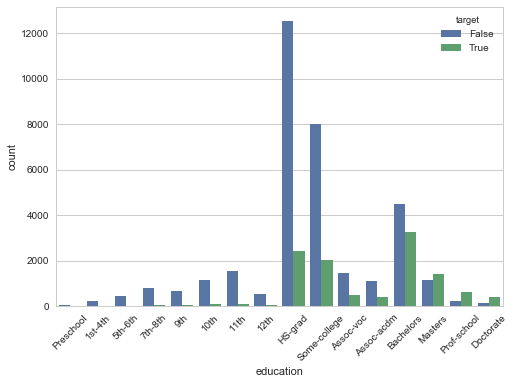

In [11]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

education = pd.DataFrame(adult[['education','education-num']].sort_values('education-num',ascending=True))
sort_edu = education.education.unique().tolist()


g=sns.countplot(x=education.education,hue='target',data=adult)
g.set_xticklabels(labels=sort_edu, rotation=45)


### 3.c Other numerical features distribution

Like you did for age, investigate the distribution of other numerical features for the 2 classes.

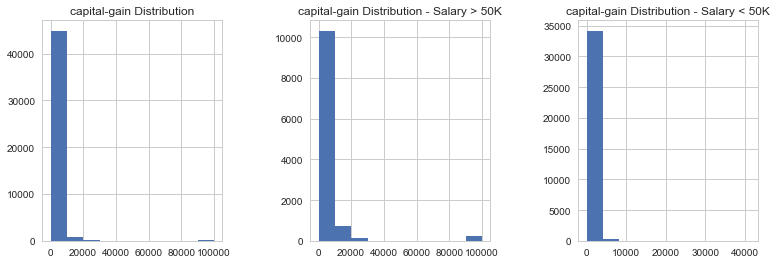

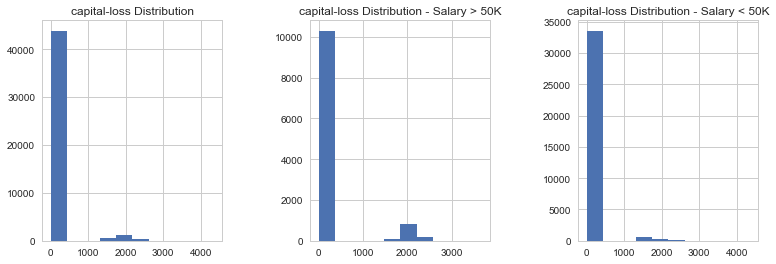

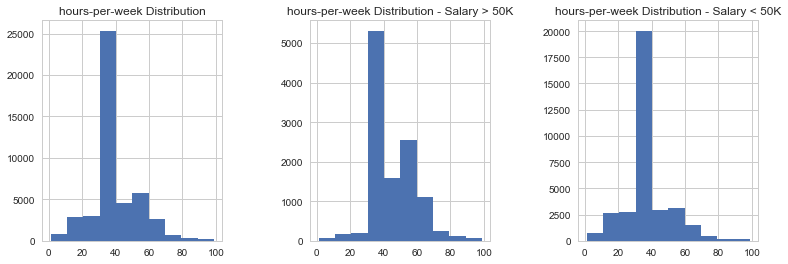

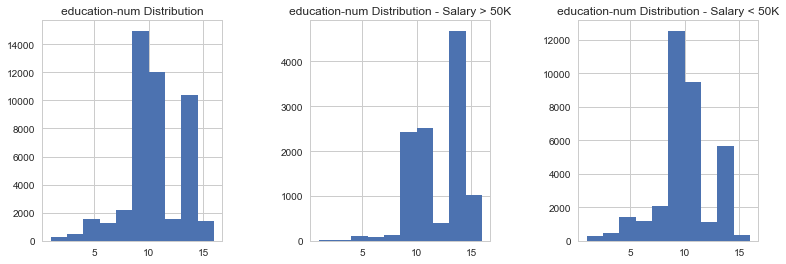

In [125]:
hist_target('capital-gain')
plt.show()
print ''

hist_target('capital-loss')
plt.show()
print ''

hist_target('hours-per-week')
plt.show()
print ''

hist_target('education-num')
plt.show()
print ''


# age                int64 NUMERICAL
# workclass         object CATEGORICAL:
# fnlwgt             int64 NUMERICAL
# education         object CATEGORICAL:
# education-num      int64 
# marital-status    object CATEGORICAL:
# occupation        object CATEGORICAL:
# relationship      object CATEGORICAL:
# race              object CATEGORICAL:
# sex               object CATEGORICAL:
# capital-gain       int64
# capital-loss       int64
# hours-per-week     int64
# native-country    object CATEGORICAL:

## 4. Dummy Columns

Scikit-Learn models require features with numerical values. In order to use all the categorical features in our model, we need to encode them into numbers. The way of doing this called 1-Hot Encoding, or dummy column creation.
Both Pandas and Scikit Learn offer an interface to do this. Please feel free to choose whichever you prefer.

Example:

|Categorical Feature|Dummy_A|Dummy_B|Dummy_C|
|---|---|---|---|
|A|1|0|0|
|B|0|1|0|
|B|0|1|0|
|C|0|0|1|
|A|1|0|0|
|C|0|0|1|
|B|0|1|0|

- [One Hot Encoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- [Get Dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)


In [183]:
import patsy

adult.columns = [x.replace('-', '_') for x in adult.columns]
# age                int64 NUMERICAL
# workclass         object CATEGORICAL:
# fnlwgt             int64 NUMERICAL
# education         object CATEGORICAL:
# education-num      int64 
# marital-status    object CATEGORICAL:
# occupation        object CATEGORICAL:
# relationship      object CATEGORICAL:
# race              object CATEGORICAL:
# sex               object CATEGORICAL:
# capital-gain       int64
# capital-loss       int64
# hours-per-week     int64
# native-country    object CATEGORICAL:
#make a new object called 'data' that sets our y (target) as Category and the other features we like as X
#Note that the 'C' before the feature name indicates that it's categorical. Its absence indicates continues variables.

X = patsy.dmatrix('~ age + C(workclass) + education_num + C(marital_status) + C(occupation) + C(relationship) + C(race) + C(sex) + capital_gain + capital_loss + hours_per_week + C(native_country)', adult)

#We need to convert our dmatrix back into a data frame to use the methods we're used to
#It would be okay to use get_dummies instead of patsy, it just requires more typing

X = pd.DataFrame(X, columns=X.design_info.column_names)
X.head()

,Intercept,C(workclass)[T.Local-gov],C(workclass)[T.Private],C(workclass)[T.Self-emp-inc],C(workclass)[T.Self-emp-not-inc],C(workclass)[T.State-gov],C(workclass)[T.Without-pay],C(marital_status)[T.Married-AF-spouse],C(marital_status)[T.Married-civ-spouse],C(marital_status)[T.Married-spouse-absent],...,C(native_country)[T.Thailand],C(native_country)[T.Trinadad&Tobago],C(native_country)[T.United-States],C(native_country)[T.Vietnam],C(native_country)[T.Yugoslavia],age,education_num,capital_gain,capital_loss,hours_per_week
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,39.0,13.0,2174.0,0.0,40.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,50.0,13.0,0.0,0.0,13.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,38.0,9.0,0.0,0.0,40.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,53.0,7.0,0.0,0.0,40.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,28.0,13.0,0.0,0.0,40.0


In [196]:
y = adult.target

## 5. Numerical Features normalization

Numerical Features may have different scales. This can be a problem in some cases, so we can try to normalize using a scaler.

Use a scaler from Scikit-learn Preprocessing to rescale the numerical features.

[Scikit-Learn Preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)

Discuss within your team about pros/cons of each scaler.

In [200]:
def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item
        print dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum() ## df.drop_duplicates() to remove dupes


eda(X)

missing_values = pd.DataFrame(X.isnull().sum(), columns=['num'])

missing_values[missing_values.num>0]

features = X.columns.tolist()


missing values 
Intercept                                          0
C(workclass)[T.Local-gov]                          0
C(workclass)[T.Private]                            0
C(workclass)[T.Self-emp-inc]                       0
C(workclass)[T.Self-emp-not-inc]                   0
C(workclass)[T.State-gov]                          0
C(workclass)[T.Without-pay]                        0
C(marital_status)[T.Married-AF-spouse]             0
C(marital_status)[T.Married-civ-spouse]            0
C(marital_status)[T.Married-spouse-absent]         0
C(marital_status)[T.Never-married]                 0
C(marital_status)[T.Separated]                     0
C(marital_status)[T.Widowed]                       0
C(occupation)[T.Armed-Forces]                      0
C(occupation)[T.Craft-repair]                      0
C(occupation)[T.Exec-managerial]                   0
C(occupation)[T.Farming-fishing]                   0
C(occupation)[T.Handlers-cleaners]                 0
C(occupation)[T.Machine-op-ins

In [199]:

# target = y.salary.unique().tolist()
# target

In [198]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)
model.coef_
# coeffs = pd.DataFrame(model.coef_, columns =features)
# coeffs
## why aren't I getting a list of coefs for both target = True, False??

array([[ -2.98830679e+00,  -6.30915110e-01,  -4.70386800e-01,
         -3.42738666e-01,  -1.00188393e+00,  -8.01454573e-01,
         -4.85326616e-02,   1.08006565e-01,   9.66618894e-01,
         -1.34146923e-01,  -5.78769490e-01,  -3.10851325e-01,
         -1.79566093e-01,   1.01897553e-02,  -1.03888346e-01,
          6.90429144e-01,  -1.01591676e+00,  -8.19858283e-01,
         -4.23802820e-01,  -1.03566228e+00,  -1.93572657e-01,
          4.97129178e-01,   3.60379205e-01,   1.51049377e-01,
          4.96904595e-01,  -2.21190096e-01,  -7.33109506e-01,
         -9.00276346e-01,  -1.52831812e+00,  -1.07392613e+00,
          8.35933892e-01,  -6.45353763e-01,  -7.20689899e-01,
         -3.92620864e-01,  -4.89185902e-01,   5.45972863e-01,
          5.78961468e-02,  -1.76764605e-01,  -2.00044527e-01,
         -5.31867280e-02,  -1.46522749e-01,  -6.25963264e-02,
         -1.32117726e-01,   2.11530929e-02,   3.36307320e-02,
         -1.15419066e-01,  -6.54995873e-02,  -7.27086541e-02,
        

In [201]:

X_norm =  StandardScaler().fit_transform(X)
model.fit(X_norm, y)

coeffs = pd.DataFrame(model.coef_, columns = features)
coeffs


,Intercept,C(workclass)[T.Local-gov],C(workclass)[T.Private],C(workclass)[T.Self-emp-inc],C(workclass)[T.Self-emp-not-inc],C(workclass)[T.State-gov],C(workclass)[T.Without-pay],C(marital_status)[T.Married-AF-spouse],C(marital_status)[T.Married-civ-spouse],C(marital_status)[T.Married-spouse-absent],...,C(native_country)[T.Thailand],C(native_country)[T.Trinadad&Tobago],C(native_country)[T.United-States],C(native_country)[T.Vietnam],C(native_country)[T.Yugoslavia],age,education_num,capital_gain,capital_loss,hours_per_week
0,0.0,-0.158297,-0.212348,-0.062936,-0.280496,-0.161182,-0.03051,0.068291,1.124096,0.016625,...,-0.043677,-0.047696,-0.182309,-0.083519,-0.001662,0.334402,0.703744,2.406389,0.265672,0.349153


## 6. Additional Exploratory Data Analysis

Conduct additional exploratory data analysis. These must include both univariate and bivariate analyses.

In [1]:
X_norm = pd.DataFrame(X_norm,columns = features)
sns.pairplot(X_norm)

NameError: name 'pd' is not defined

## 7. Combine Features

Combine the dummy features and the scaled feature into a single dataset called `X`.

Rename the target variable `y`.

What's the accuracy score of a benchmark model? What's the simplest model you could build?

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2, SelectPercentile, GenericUnivariateSelect, f_classif
knn = KNeighborsClassifier()
#build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

#train the selector on our data
skb_f.fit(X, y)
skb_chi2.fit(X, y)

#examine results
pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)

## 8. Build and evaluate model

Build a model using KNN or Logistic regression.

Split your data into train and test subset using the following line:

    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
1. Evaluate the `accuracy_score` of your model.
- Display the confusion matrix and the classification report
- Try to improve the model by tuning the parameters. For example:
    - KNN: Change the number of Neighbors
    - LogisticRegression: Change the strength of the regularization
    
Discuss and compare your best model with other teams
